### В этом проекте я проанализирую данные об оттоке клиентов банка
### Выберу лучший классификатор для прогноза оттока клиентов

In [1]:
#Импорт библиотек 
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import seaborn as sns

/home/konstantin/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('/home/konstantin/Jupyter_Notebook/Отток клиентов банка/Bank Customer Churn Prediction.csv')

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Пояснение к параметрам df:

1. customer_id - идентификатор пользователя
2. credit_score - балл, определяющий кредитоспособность клиента
3. country - страна, в которой проживает клиент
4. gender - пол клиента
5. age - возраст клиента
6. tenure - количество лет, в течение которых клиент имеет банковский счет в данном банке
7. balance - количество денег на счету
8. products_number - количесвто продуктов банка
9. credit_card - есть ли у клиента кредитная карта
10. active_member - активный ли клиент
11. estimated_salary - общий доход клиента
12. churn - отток банка(потеря существующего клиента), 1 - если клиент покинул банк, 0 - если не покинул

Проверка типа данных, пропущенных значений и повторов

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [5]:
df.duplicated().sum()

0


###### Проверим корреляцию признаков


In [6]:
df = df.drop('customer_id', axis = 1)

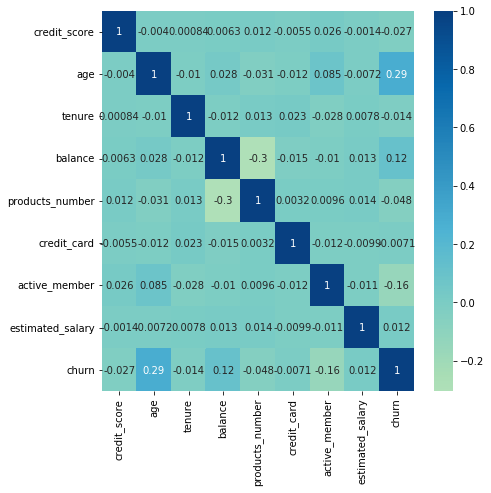

In [7]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(), cmap = 'GnBu', center =0, annot=True)

###### Нас интересует корреляция с признаком churn

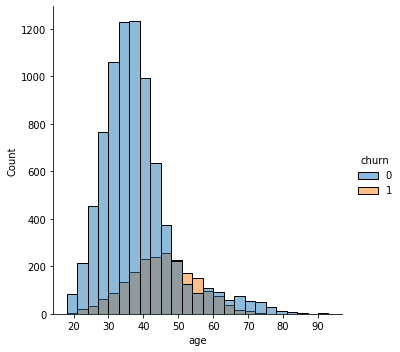

In [8]:
sns.displot(data=df, x='age', hue = 'churn', binwidth=3)

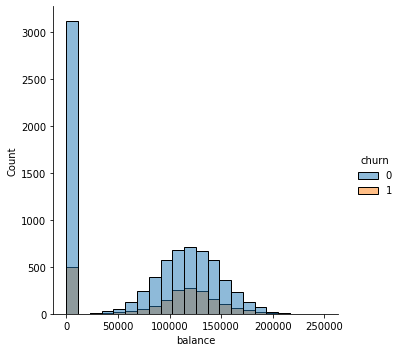

In [10]:
sns.displot(data=df, x='balance', hue = 'churn')

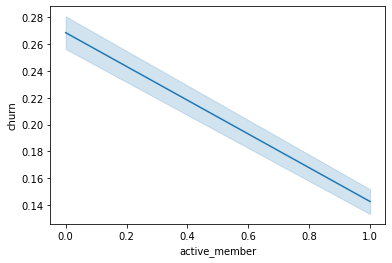

In [9]:
sns.lineplot(data=df, x='active_member', y = 'churn')

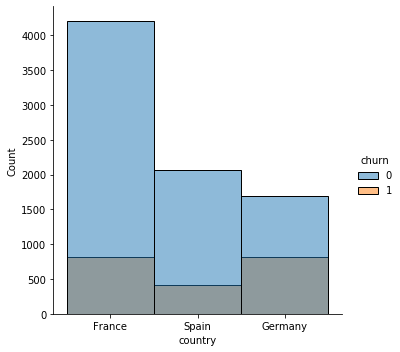

In [10]:
sns.displot(data=df, x='country', hue = 'churn')

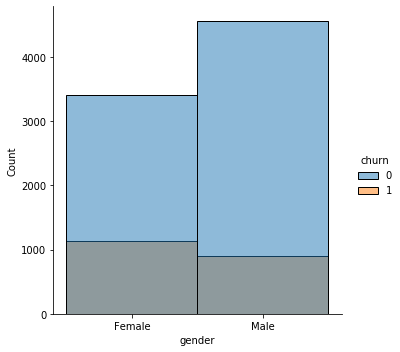

In [32]:
sns.displot(data=df, x='gender', hue = 'churn')

###### Вывод:

- Самая высокая корреляция оттока клиентов у старшего поколения, после 40 лет.

- Французы покидают банк реже, немцы чаще. По графику заметно, что это может быть связано с представительством банков в конкретной стране.

- Активные клиенты реже покидают банк.

- Мужчины реже покидают банк, в пропорции их больше. Женщины чаще.

- Баланс имеет положительную корреляцию. Клиенты с большим балансом, склонны чаще покидать банк.

([<matplotlib.patches.Wedge at 0x7fc663d4de50>,
 [Text(-0.8823431426537007, 0.6568642010431011, '0'),
  Text(0.8823431426537006, -0.6568642010431012, '1')],
 [Text(-0.48127807781110943, 0.3582895642053278, '80%'),
  Text(0.4812780778111093, -0.35828956420532787, '20%')])

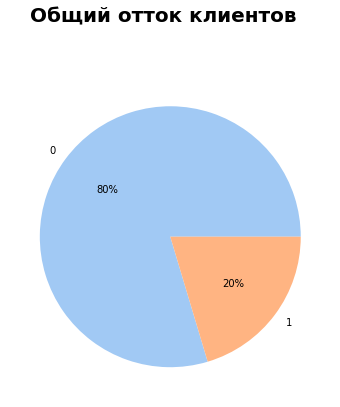

In [11]:
f=plt.subplots(figsize=(12, 6))

data = df.churn.value_counts()
label = [data.index[0],data.index[1]]
color = sns.color_palette('pastel')[0:2]
plt.figtext(0.35, 1, 'Общий отток клиентов', size=20, color='black', fontweight='bold')

plt.pie(data, labels=label, colors = color, autopct='%.0f%%')

###### Точность прогноза ожидаем на уровне 80%

## Выберем подходящую модель для прогноза. 
### В данном случае у нас задача классификации

Закодируем номинативные переменные и разобъем на сплиты

In [12]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [15]:
X = df.drop(['churn'], axis = 1)
y = df['churn']
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.33,random_state = 42)


In [35]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:14<00:00,  1.94it/s]


In [36]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.87,0.73,0.73,0.86,0.34
XGBClassifier,0.86,0.72,0.72,0.85,0.42
AdaBoostClassifier,0.86,0.72,0.72,0.85,0.36
RandomForestClassifier,0.87,0.71,0.71,0.85,0.75
BaggingClassifier,0.85,0.71,0.71,0.84,0.23
ExtraTreesClassifier,0.86,0.70,0.70,0.85,0.65
DecisionTreeClassifier,0.79,0.68,0.68,0.79,0.11
SVC,0.86,0.68,0.68,0.84,0.93
NearestCentroid,0.69,0.68,0.68,0.72,0.05


В данном случае, я обращу внимание на метрику Balanced Accuracy, 
потому что работаю с несбалансированным набором данных. 

Так как значения некоторых классификаторов близки, 
рассмотрю так же время затраченной на работу классификатора.

Text(0.27, 1, 'Balanced Accuracy моделей классификации')

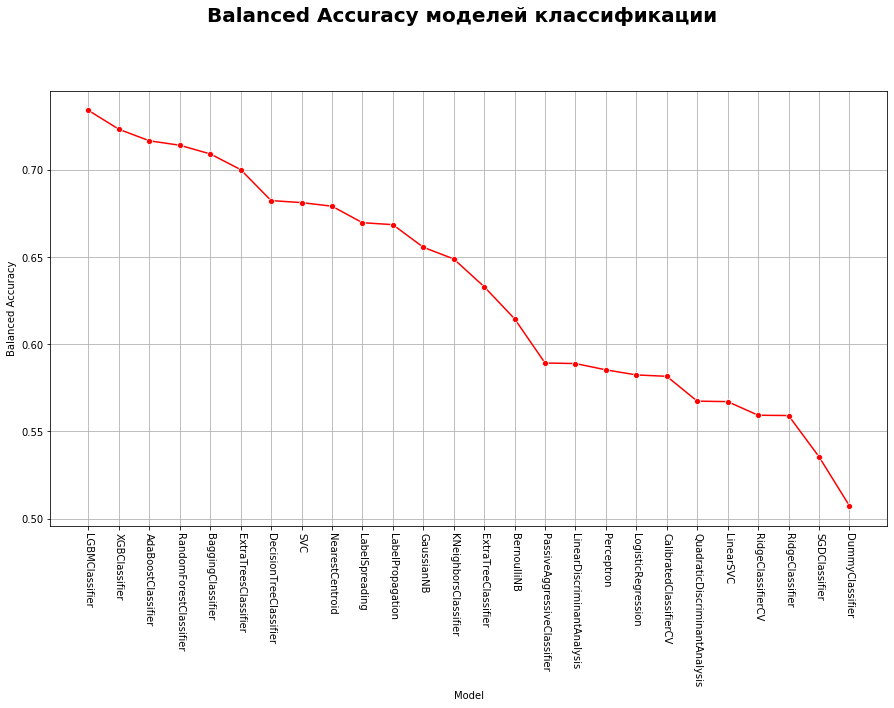

In [62]:
models.sort_values(by = 'Balanced Accuracy',inplace = True,ascending = False)
f=plt.subplots(figsize=(15, 8))

ax = sns.lineplot(data=models, x='Model', y = 'Balanced Accuracy', marker = 'o', color = 'red')
ax.grid(axis = 'both')
plt.xticks(rotation=270)
plt.figtext(0.27, 1, 'Balanced Accuracy моделей классификации', size=20, color='black', fontweight='bold')

Text(0.29, 1, 'Time Taken моделей классификации')

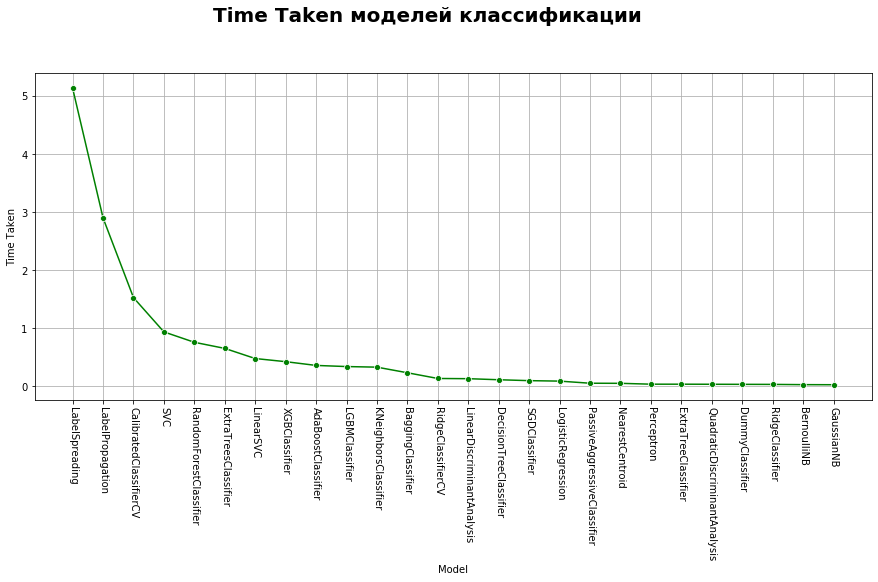

In [63]:
models.sort_values(by = 'Time Taken',inplace = True,ascending = False)
f=plt.subplots(figsize=(15, 6))

ax = sns.lineplot(data=models, x='Model', y = 'Time Taken', marker = 'o', color = 'green')
ax.grid(axis = 'both')
plt.xticks(rotation=270)
plt.figtext(0.29, 1, 'Time Taken моделей классификации', size=20, color='black', fontweight='bold')

###### По соотношению затраченного времени и точности предсказаний, выберем 3 лучших классификатора:
- LGBMClassifier, 
- XGBClassifier, 
- AdaBoostClassifier

В зависимости от выбранной метрики, можно работать над точностью предсказания моделей.
